# Residual Neural Network for image classification
Very deep neural networks suffer from a problem called **vanishing/exploding gradients**. In the year 2015 Kaiming He, et al proposed a solution for this in their research paper [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf). A Residual Network, also known as *ResNet*, is a type of deep learning network architecture that introduces the concept of *residual learning*.

In this project I will be implementing a ResNet using ResNet50 architecture which consists of 50 layers.

<div><div class="alert alert-info">
    <h3>Table of content:</h3>
    <ol>
        <li><a href="#create_idetity_block">Create Identity block</a></li>
        <li><a href="#conv_block">Convolutional Block</a></li>
        <li><a href="#resnet50_function">Implement ResNet (50 Layers)</a></li>
        <li><a href="#configure_learning_process">Configure Learning Process</a></li>
        <li><a href="#load_dataset">Load Dataset</a></li>
        <li><a href="#train_model">Train ResNet50</a></li>
        <li><a href="#save_model">Save the model</a></li>
    </ol>
</div>

In [1]:
import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from resnets_utils import *
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from matplotlib.pyplot import imshow

%matplotlib inline

<a id="create_idetity_block"></a>
## Identity block
<p>ResNet architecture introduces the concept of residual learning, where the input from the previous layer is added to the output of the current layer.</p>
<p>An <b>Identity Block</b> is a specific type of residual block where the <i><b>input and output have the same dimensions</b></i>.</p>
<p>This is the plan to build Identity block. <b>Identity block.</b> Skip connection "skips over" 3 layers.</p>

<img src="images/idblock.png" width="750">

In [2]:
def identity_block(X, f, filters, initializer=random_uniform):
    """
    Implementation of the identity block.
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prew, n_C_prev)
    f -- integer, specifying the shape of the number of filters in the CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    initializer -- to set up the initial weights of a layer. Equals to random iniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. We'll need this later to add back to the main path
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters=F1, kernel_size=1, strides=(1, 1), padding='valid', kernel_initializer=initializer(seed=24))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=f, strides=(1, 1), padding='same', kernel_initializer=initializer(seed=24))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    
    # Third component of the main path
    X = Conv2D(filters=F3, kernel_size=1, strides=(1, 1), padding='same', kernel_initializer=initializer(seed=24))(X)
    X = BatchNormalization(axis=3)(X)
    
    # Final step: Add shortcut value to main path, and pass it throuh a ReLU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

<a id="conv_block"></a>
## Convolutional Block
<p>A convolutional block is another type of building block that makes up the overall architecture of ResNet. Unlike the identity block, which preserves the input identity, convolutional block is designed to change the dimensions of the input.</p>

<img src="images/convblock.png" width="750" />

In [3]:
def convolutional_block(X, f, filters, s = 2, initializer=glorot_uniform):
    """
    Implementation of the convolutional block.
    
    Arguments:
    X -- Input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- Integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrive Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X
    
    ### Main Path ###
    # First component of main path
    X = Conv2D(filters=F1, kernel_size=1, strides=(s, s), padding='valid', kernel_initializer=initializer(seed=24))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    
    # Second component of the main path
    X = Conv2D(filters=F2, kernel_size=f, strides=(1, 1), padding='same', kernel_initializer=initializer(seed=24))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    
    # Third component of the main path
    X = Conv2D(filters=F3, kernel_size=1, strides=(1, 1), padding='valid', kernel_initializer=initializer(seed=24))(X)
    X = BatchNormalization(axis=3)(X)
    
    ### Shortcut Path ###
    X_shortcut = Conv2D(filters=F3, kernel_size=1, strides=(s, s), padding='valid', kernel_initializer=initializer(seed=24))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut)
    
    # Final step: Add shourtcut value to the main path
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

<a id="resnet50_function"></a>
## Building the ResNet (50 layers)
<p><a href="https://arxiv.org/pdf/1512.03385.pdf" target="_blank">ResNet50</a> in a very popular Residual Network architecture. Now we have all necessary building blocks to build our ResNet.</p>
<p>Following diagram shows the architecture of the ResNet I'm building in this project.</p>
<ul>
    <li><b>ID BLOCK</b> in the diagram stands for "Identity Block"</li>
    <li><b>ID BLOCK x3</b> means 3 identity blocks are stacked together</li>
</ul>

<img src="images/resnet.png" />

In [4]:
def ResNet50(input_shape=(64, 64, 3), classes=6, training=False):
    """
    Stage-wise implementation of the architecture of the popular ResNet50
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE
    
    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes
    
    Return:
    model -- a Model() instance in Keras    
    """
    
    # Define the input as a tensor with shape input input_shape
    X_input = Input(input_shape)
    
    # Zero padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), kernel_initializer=glorot_uniform(seed=24))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], s=1)
    X = identity_block(X, f=3, filters=[64, 64, 256])
    X = identity_block(X, f=3, filters=[64, 64, 256])
    
    # Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], s=2)
    X = identity_block(X, f=3, filters=[128, 128, 512])
    X = identity_block(X, f=3, filters=[128, 128, 512])
    X = identity_block(X, f=3, filters=[128, 128, 512])
    
    # Stage 4
    X = convolutional_block(X, f=3, filters=[512, 512, 1024], s=2)
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    
    # Stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], s=2)
    X = identity_block(X, f=3, filters=[512, 512, 2048])
    X = identity_block(X, f=3, filters=[512, 512, 2048])
    
    # AveragePool
    X = AveragePooling2D(pool_size=(2, 2))(X)
    
    # Output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer=glorot_uniform(seed=24))(X)
    
    # Create model
    model = Model(inputs=X_input, outputs=X)
    
    return model

In [5]:
model = ResNet50(input_shape=(64, 64, 3), classes=6, training=True)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 70, 70, 3)            0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           9472      ['zero_padding2d[0][0]']      
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 64)           256       ['conv2d[0][0]']          

<a id="configure_learning_process"></a>
## Configure the learning process

In [6]:
np.random.seed(1)
tf.random.set_seed(2)
opt = tf.keras.optimizers.Adam(learning_rate=0.00015)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

<a id="load_dataset"></a>
## Load the Dataset

In [7]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.

# Convert training and testing labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


<a id="train_model"></a>
## Train ResNet50

In [8]:
model.fit(X_train, Y_train, epochs=50, batch_size=32, verbose=2)

Epoch 1/50
34/34 - 79s - loss: 1.6604 - accuracy: 0.3519 - 79s/epoch - 2s/step
Epoch 2/50
34/34 - 67s - loss: 0.8772 - accuracy: 0.6907 - 67s/epoch - 2s/step
Epoch 3/50
34/34 - 66s - loss: 0.5759 - accuracy: 0.7880 - 66s/epoch - 2s/step
Epoch 4/50
34/34 - 67s - loss: 0.3167 - accuracy: 0.8917 - 67s/epoch - 2s/step
Epoch 5/50
34/34 - 67s - loss: 0.1880 - accuracy: 0.9352 - 67s/epoch - 2s/step
Epoch 6/50
34/34 - 53s - loss: 0.1758 - accuracy: 0.9370 - 53s/epoch - 2s/step
Epoch 7/50
34/34 - 48s - loss: 0.1484 - accuracy: 0.9472 - 48s/epoch - 1s/step
Epoch 8/50
34/34 - 47s - loss: 0.1786 - accuracy: 0.9398 - 47s/epoch - 1s/step
Epoch 9/50
34/34 - 47s - loss: 0.1387 - accuracy: 0.9528 - 47s/epoch - 1s/step
Epoch 10/50
34/34 - 48s - loss: 0.1037 - accuracy: 0.9657 - 48s/epoch - 1s/step
Epoch 11/50
34/34 - 49s - loss: 0.0700 - accuracy: 0.9806 - 49s/epoch - 1s/step
Epoch 12/50
34/34 - 48s - loss: 0.0579 - accuracy: 0.9787 - 48s/epoch - 1s/step
Epoch 13/50
34/34 - 47s - loss: 0.0703 - accuracy

### model performance on test set

In [9]:
preds = model.evaluate(X_test, Y_test)
print("Loss = " + str(preds[0]))
print("Accuracy = " + str(preds[1]))

4/4 [==============================] - 2s 116ms/step - loss: 0.3010 - accuracy: 0.9333
Loss = 0.3009777069091797
Accuracy = 0.9333333373069763


<a id="save_model"></a>
## Save model

In [10]:
model.save('models/resnet50.keras')

C:\Users\navilog\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Test on our own images

In [80]:
def imageToArray(imageName):
    # Load the image and resize it to the desired dimensions
    #image_path = f'images/{imageName}'
    image_path = f'images/test_images/{imageName}'
    width, height = 64, 64

    image = Image.open(image_path)
    image = image.resize((width, height))
    #print(image.width)
    # Convert the image to a NumPy array and normalize the pixel values (if necessary)
    image_array = np.asarray(image)
    image_array = image_array / 255.  # Normalize the pixel values between 0 and 1
    
    plt.imshow(image_array)
    plt.show()

    print(image_array.shape)
    # Reshape the image array to match the input shape of your model
    image_array = image_array.reshape(1, width, height, 3)  # Assumes the input shape is (width, height, 3)

    return image_array

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

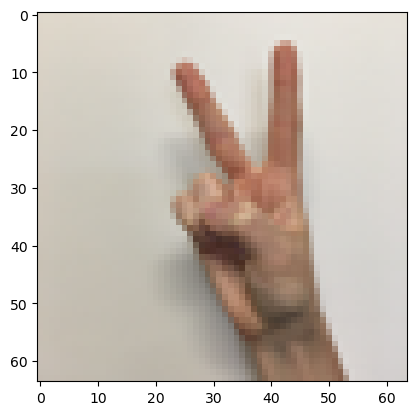

(64, 64, 3)
1/1 [==============================] - 0s 70ms/step
2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

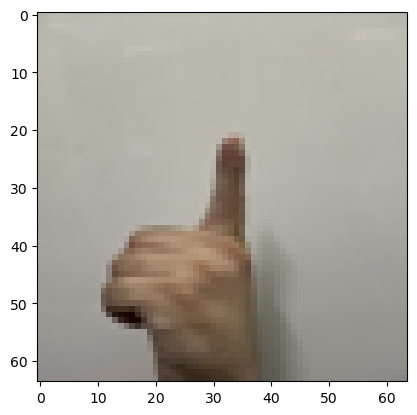

(64, 64, 3)
1/1 [==============================] - 0s 50ms/step
5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

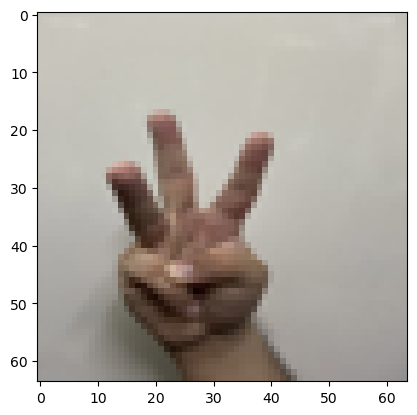

(64, 64, 3)
1/1 [==============================] - 0s 47ms/step
4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

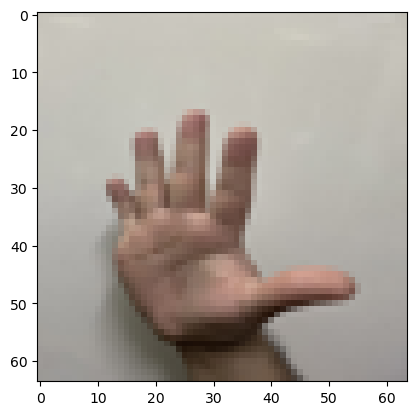

(64, 64, 3)
1/1 [==============================] - 0s 46ms/step
5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

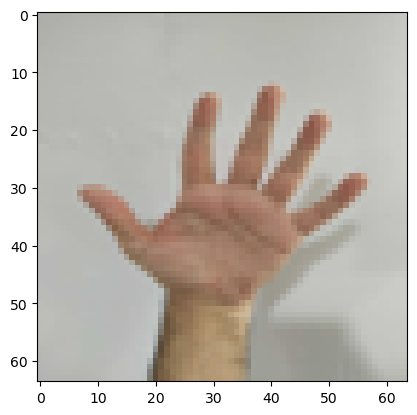

(64, 64, 3)
1/1 [==============================] - 0s 45ms/step
5


In [81]:
#test_images = ['0.jpg', '1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpeg', '8.jpeg', '9.jpeg', '10.jpg']
test_images = ['6.jpg', '7.jpg', '8.jpg', '9.jpg', '10.jpg']
for img in test_images:
    img_array = imageToArray(img)
    predicted = model.predict(img_array)
    print(np.argmax(predicted))